In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

from utils import calibrate_camera, show_img, grid_view, view_imgs, binary_threshold_v1, binary_threshold_v2

binary_threshold = binary_threshold_v1

## Camera calibration
In this part, we calibrate our camera using images from `camera_cal`, note that since doing camera calibration is slow, we dump it to a pickle file so that we can reuse later

In [2]:
img_files = np.sort(glob.glob('camera_cal/calibration*.jpg'))
Nx = 9
Ny = 5

# do camera calibration if we have done it
if not os.path.isfile('camera_calib.pkl'):
    img_WH, mtx, dist, rvecs, tvecs = calibrate_camera(img_files, Nx, Ny)
    with open('camera_calib.pkl', 'wb') as f:
        cam_calib = {'img_WH' : img_WH,
                     'mtx'    : mtx,
                     'dist'   : dist,
                     'rvecs'  : rvecs,
                     'tvecs'  : tvecs}
        pickle.dump(cam_calib, f)
else:
    with open('camera_calib.pkl', 'rb') as f:
        cam_calib = pickle.load(f)
        img_WH, mtx, dist, rvecs, tvecs = [cam_calib[k] for k in ['img_WH', 'mtx', 'dist', 'rvecs', 'tvecs']]


Test the calirated camera

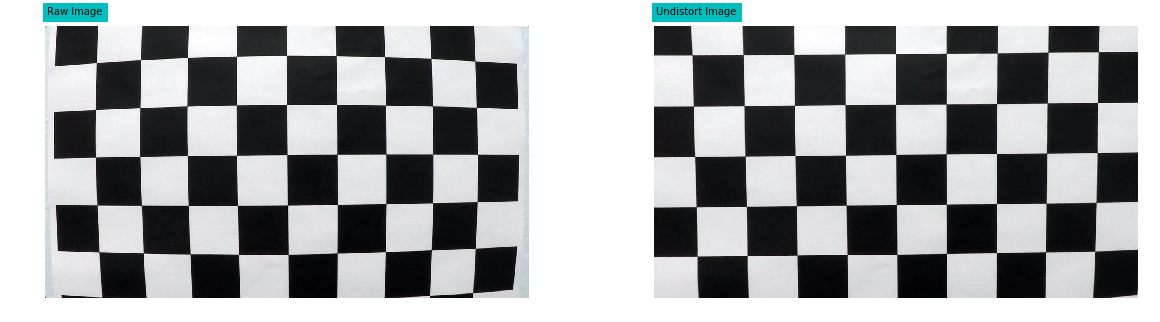

In [3]:
raw_img = cv2.imread(img_files[0])
undist_img = cv2.undistort(raw_img, mtx, dist, None, mtx)

view_imgs([raw_img, undist_img], ['Raw Image', 'Undistort Image'], figsize=(20,5))

## Pipeline (single images)
We will use the straight-lane-line image `test_images/straight_lines1.jpg` as test example.

### Undistort camera input
First let's look at undistort image

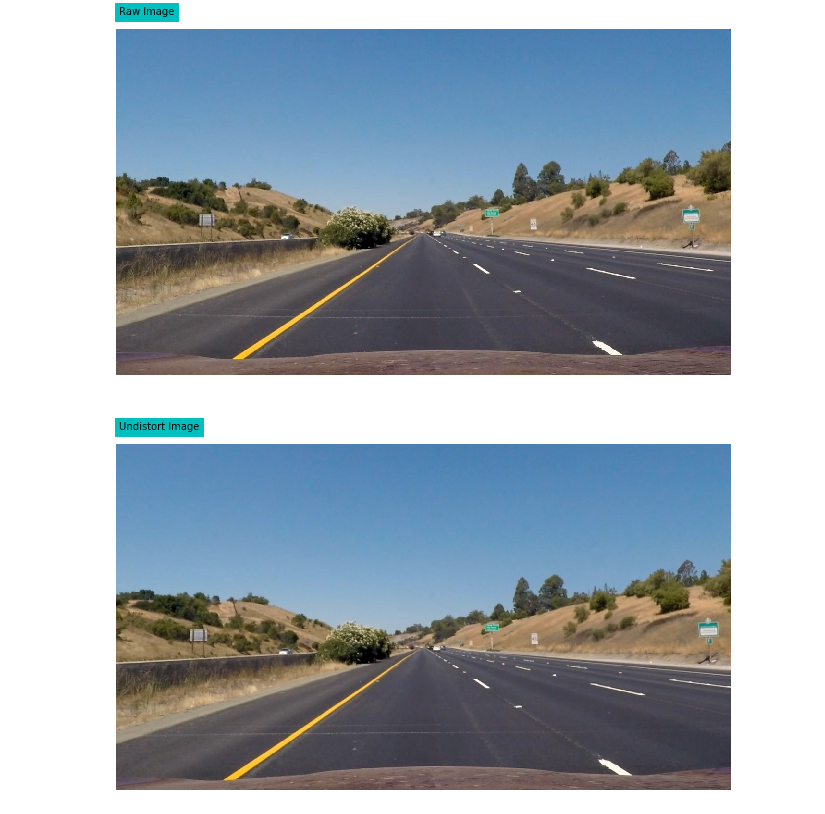

In [4]:
test_files = np.sort(glob.glob('test_images/*.jpg'))
raw_img = mpimg.imread(test_files[0])
undist_img = cv2.undistort(raw_img, mtx, dist, None, mtx)
view_imgs([raw_img, undist_img], ['Raw Image', 'Undistort Image'], figsize=(14,14), multi_col=False)

### Threshold binary images
We will apply a combination of

 * absolute Sobel threshold in x/y direction
 * magnitute Sobel threshold
 * direction threshold
 * color threshold using S-channel of HLS color-space

Here is the output of the above undistort image

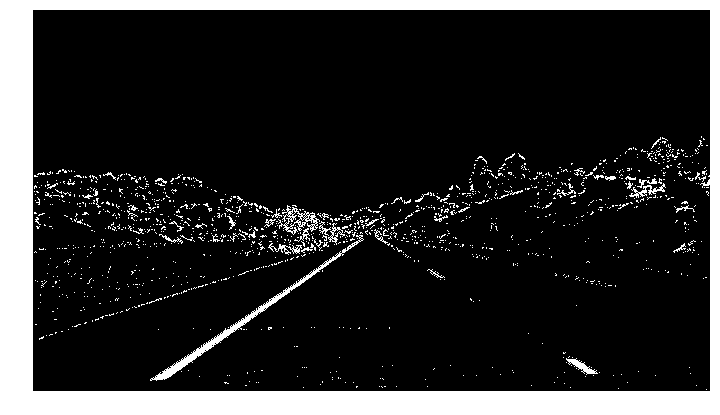

In [5]:
undist_img_bin = binary_threshold(undist_img)
show_img(undist_img_bin, None, cmap='gray', figsize=(14,7))

### Perspective transform
Now we want to view the road from bird-eye view

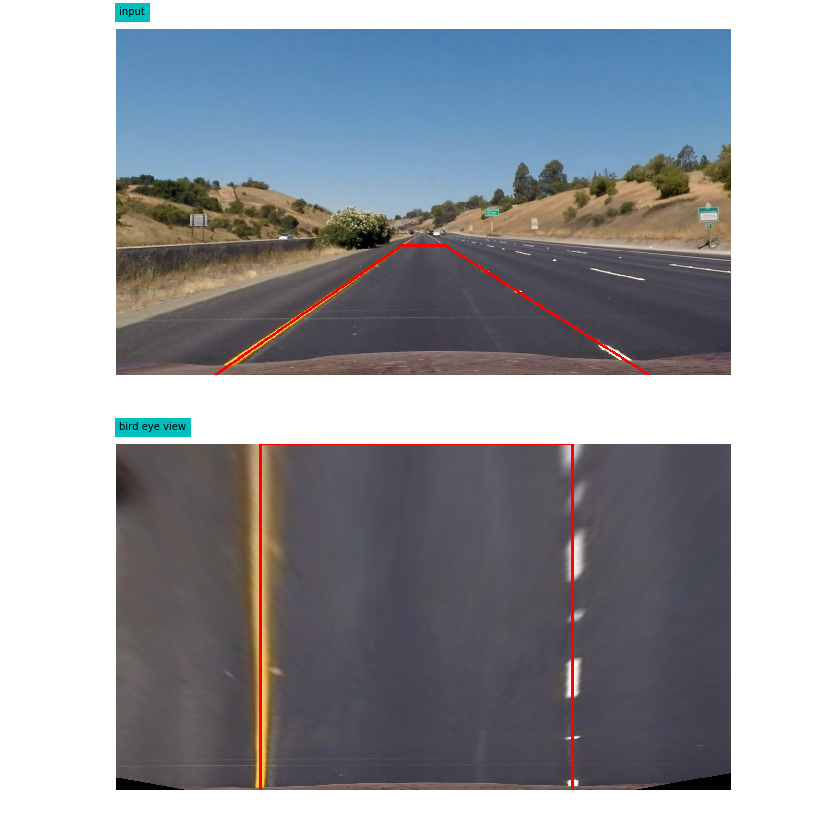

In [6]:
from utils import warper, src_points, dst_points

def view_perspective_trans(rgb_in):
    img = np.copy(rgb_in)
    warped = warper(img)        
    # draw line
    for i in range(3):
        cv2.line(img,    tuple(src_points[i]), tuple(src_points[i+1]), color=[255, 0, 0], thickness=4)
        cv2.line(warped, tuple(dst_points[i]), tuple(dst_points[i+1]), color=[255, 0, 0], thickness=4)
    
    view_imgs([img, warped], ['input', 'bird eye view'], figsize=(14,14), multi_col=False)
    
view_perspective_trans(undist_img)

And the perspective transformation if the binary image

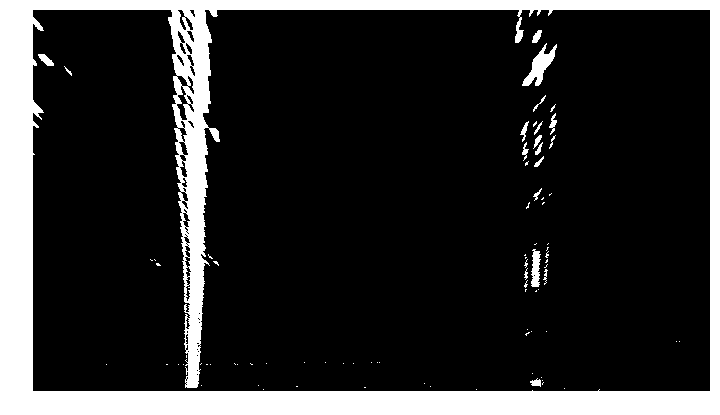

In [7]:
binary_warped = warper(undist_img_bin)
show_img(binary_warped, None, cmap='gray', figsize=(14,7))

### Find lane-line
We will use `find_lane_line_hist` or `find_lane_line_conv` for this task

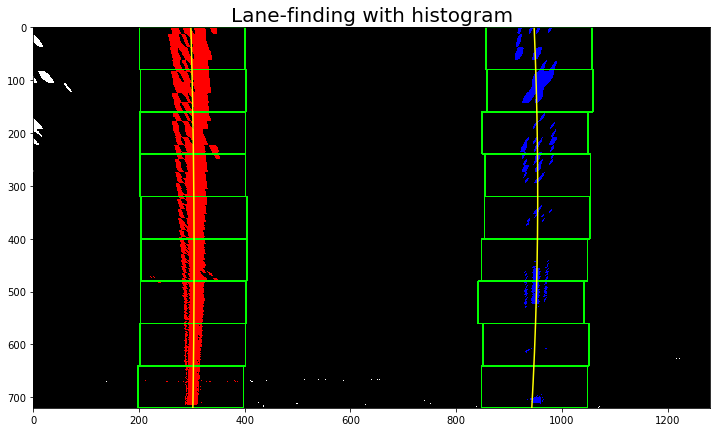

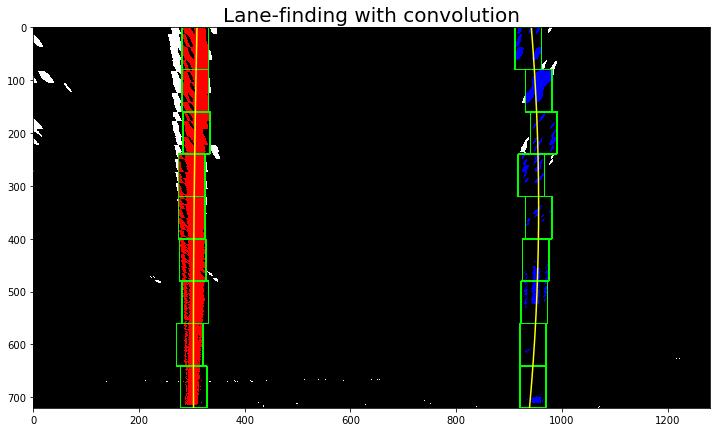

In [8]:
from lane_lines import find_lane_line_hist, find_lane_line_conv, visualize_lane_line

hist_lr_fits, hist_lr_points, hist_lr_windows = find_lane_line_hist(binary_warped, 9, debug=True)
conv_lr_fits, conv_lr_points, conv_lr_windows = find_lane_line_conv(binary_warped, 9, debug=True)

visualize_lane_line(binary_warped, hist_lr_fits, hist_lr_points, hist_lr_windows, 'Lane-finding with histogram')
visualize_lane_line(binary_warped, conv_lr_fits, conv_lr_points, conv_lr_windows, 'Lane-finding with convolution')

### Measuring curvature and car position
Using `measure_curvature` and `measure_offset` we obtain the following result for above input

In [9]:
from utils import measure_curvature, measure_offset
img_W, img_H = img_WH
l_radius, r_radius = measure_curvature(img_H, hist_lr_fits)
pos_offset = measure_offset(img_H, img_W, hist_lr_fits)
print ('Left-right radius(m)   = {:.0f}, {:.0f}'.format(l_radius, r_radius))

if (pos_offset > 1e-2): 
    left_or_right = ' right '
elif (pos_offset < -1e-2):
    left_or_right = ' left '
else:
    left_or_right = ' '
print ('Car position offset(m) = {:.2f}{}of the center'.format(pos_offset, left_or_right))

Left-right radius(m)   = 5000, 2411
Car position offset(m) = 0.07 right of the center


### Draw lane-line onto the road
Now we draw our result onto the original road image

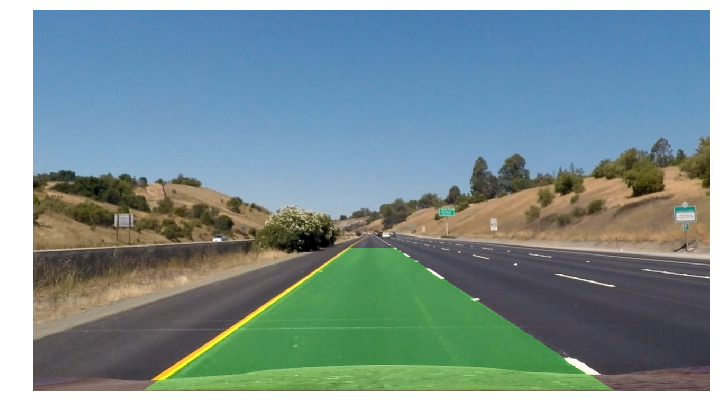

In [10]:
from lane_lines import draw_lane_area
lane_line_img = draw_lane_area(undist_img, binary_warped, hist_lr_fits)
show_img(lane_line_img, None, figsize=(14,7))

### Pipeline on single image
Now we put all above step inside `pipeline_single_image` and we test all images in test_images

In [26]:
from pipeline import pipeline_single_image
lane_line_imgs = []
for img_file in test_files:
    raw_rgb = mpimg.imread(img_file)
    lane_line = pipeline_single_image(raw_rgb, mtx, dist)
    mpimg.imsave('output_images/{}'.format(os.path.basename(img_file)))
    lane_line_imgs.append(lane_line)

TypeError: imsave() missing 1 required positional argument: 'arr'

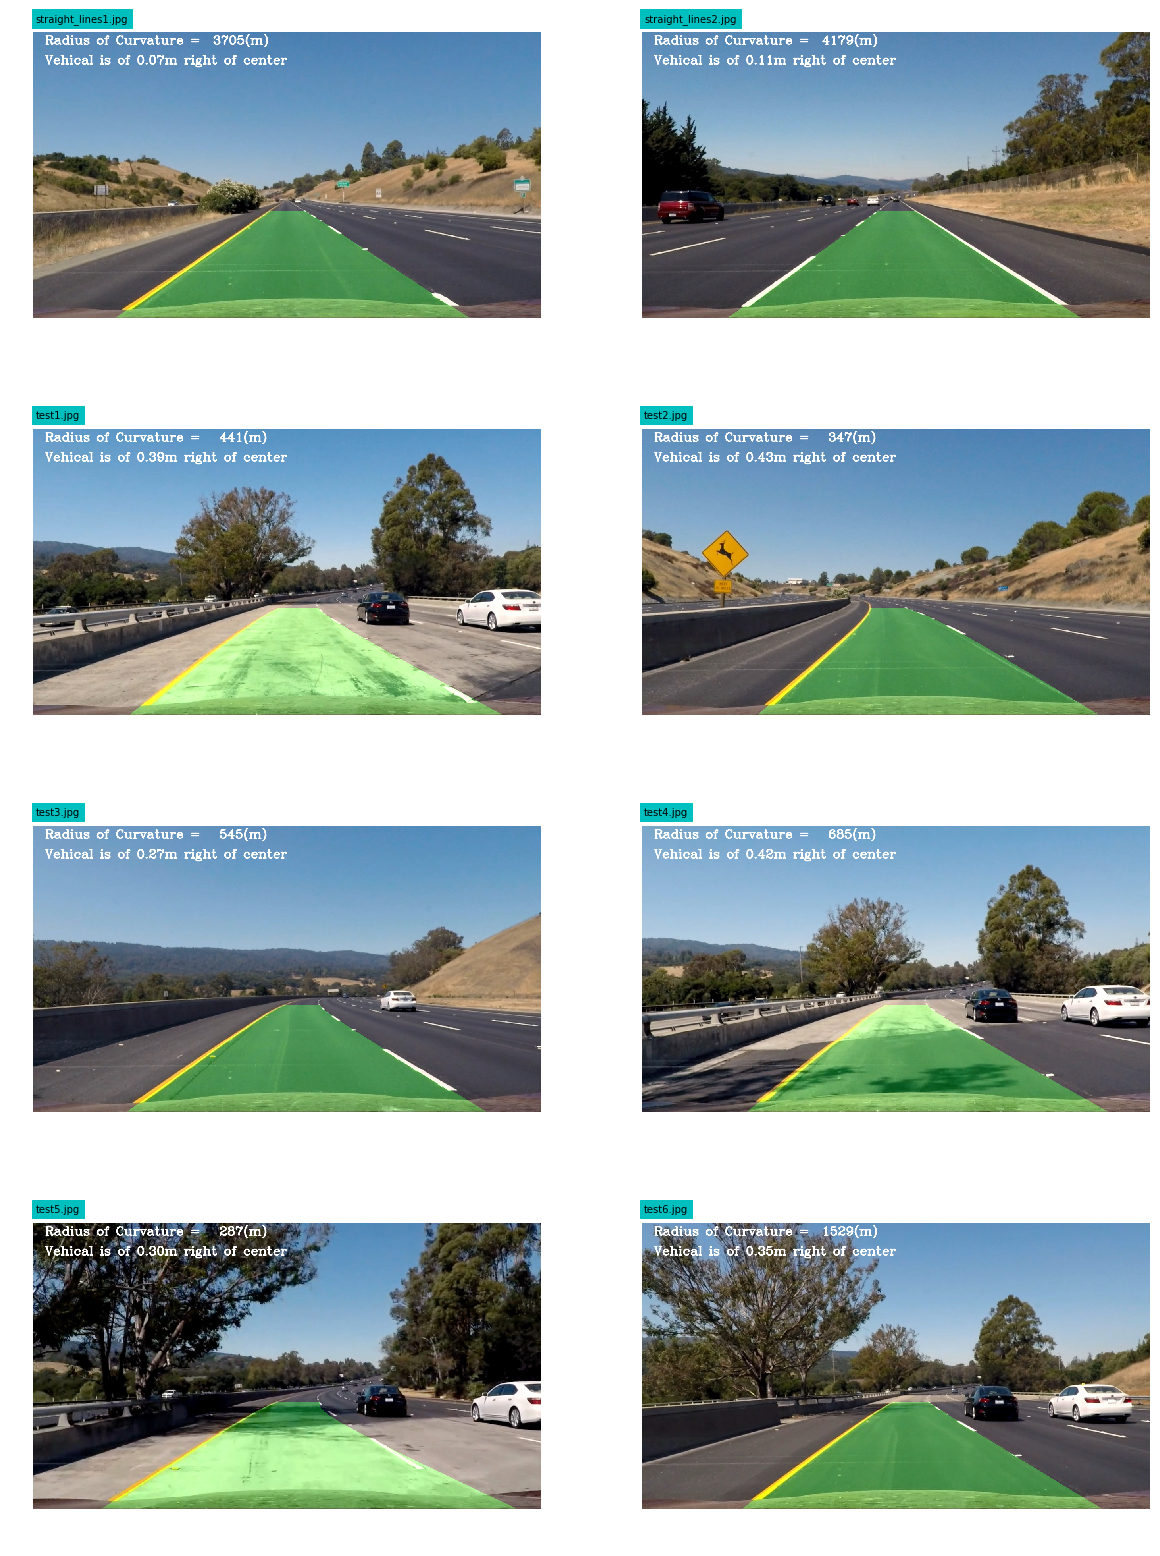

In [12]:
labels = [os.path.basename(img_file) for img_file in test_files]
grid_view(lane_line_imgs, labels, (20,28), 4, 2)

## Pipeline (video)
Now we will try above pipeline on `project_video.mp4`. First, we use a naive approach where we read each frame of the clip and run the above pipeline for each frame (see function `pipeline_video_naive` in `pipeline.py` for more detail)

In [13]:
from pipeline import pipeline_video_naive
from IPython.display import HTML
in_clip  = 'project_video.mp4'
out_clip = 'project_video_naive_v1.mp4'

In [14]:
pipeline_video_naive(in_clip, mtx, dist, out_clip)

[MoviePy] >>>> Building video project_video_naive_v1.mp4
[MoviePy] Writing video project_video_naive_v1.mp4


100%|█████████▉| 1260/1261 [03:56<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_naive_v1.mp4 

File is saved to project_video_naive_v1.mp4


We can play the output clip 

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_clip))

Examine the above video, we notice that some frame around 42 seconds, the lane-line is not very well detected. Let's check the image to see why it fails to identify the lane line.

In [16]:
from utils import video2images
_ = video2images(in_clip, 'video_frame/project_video')

1260 frames are saved to video_frame/project_video, took 417.63 seconds


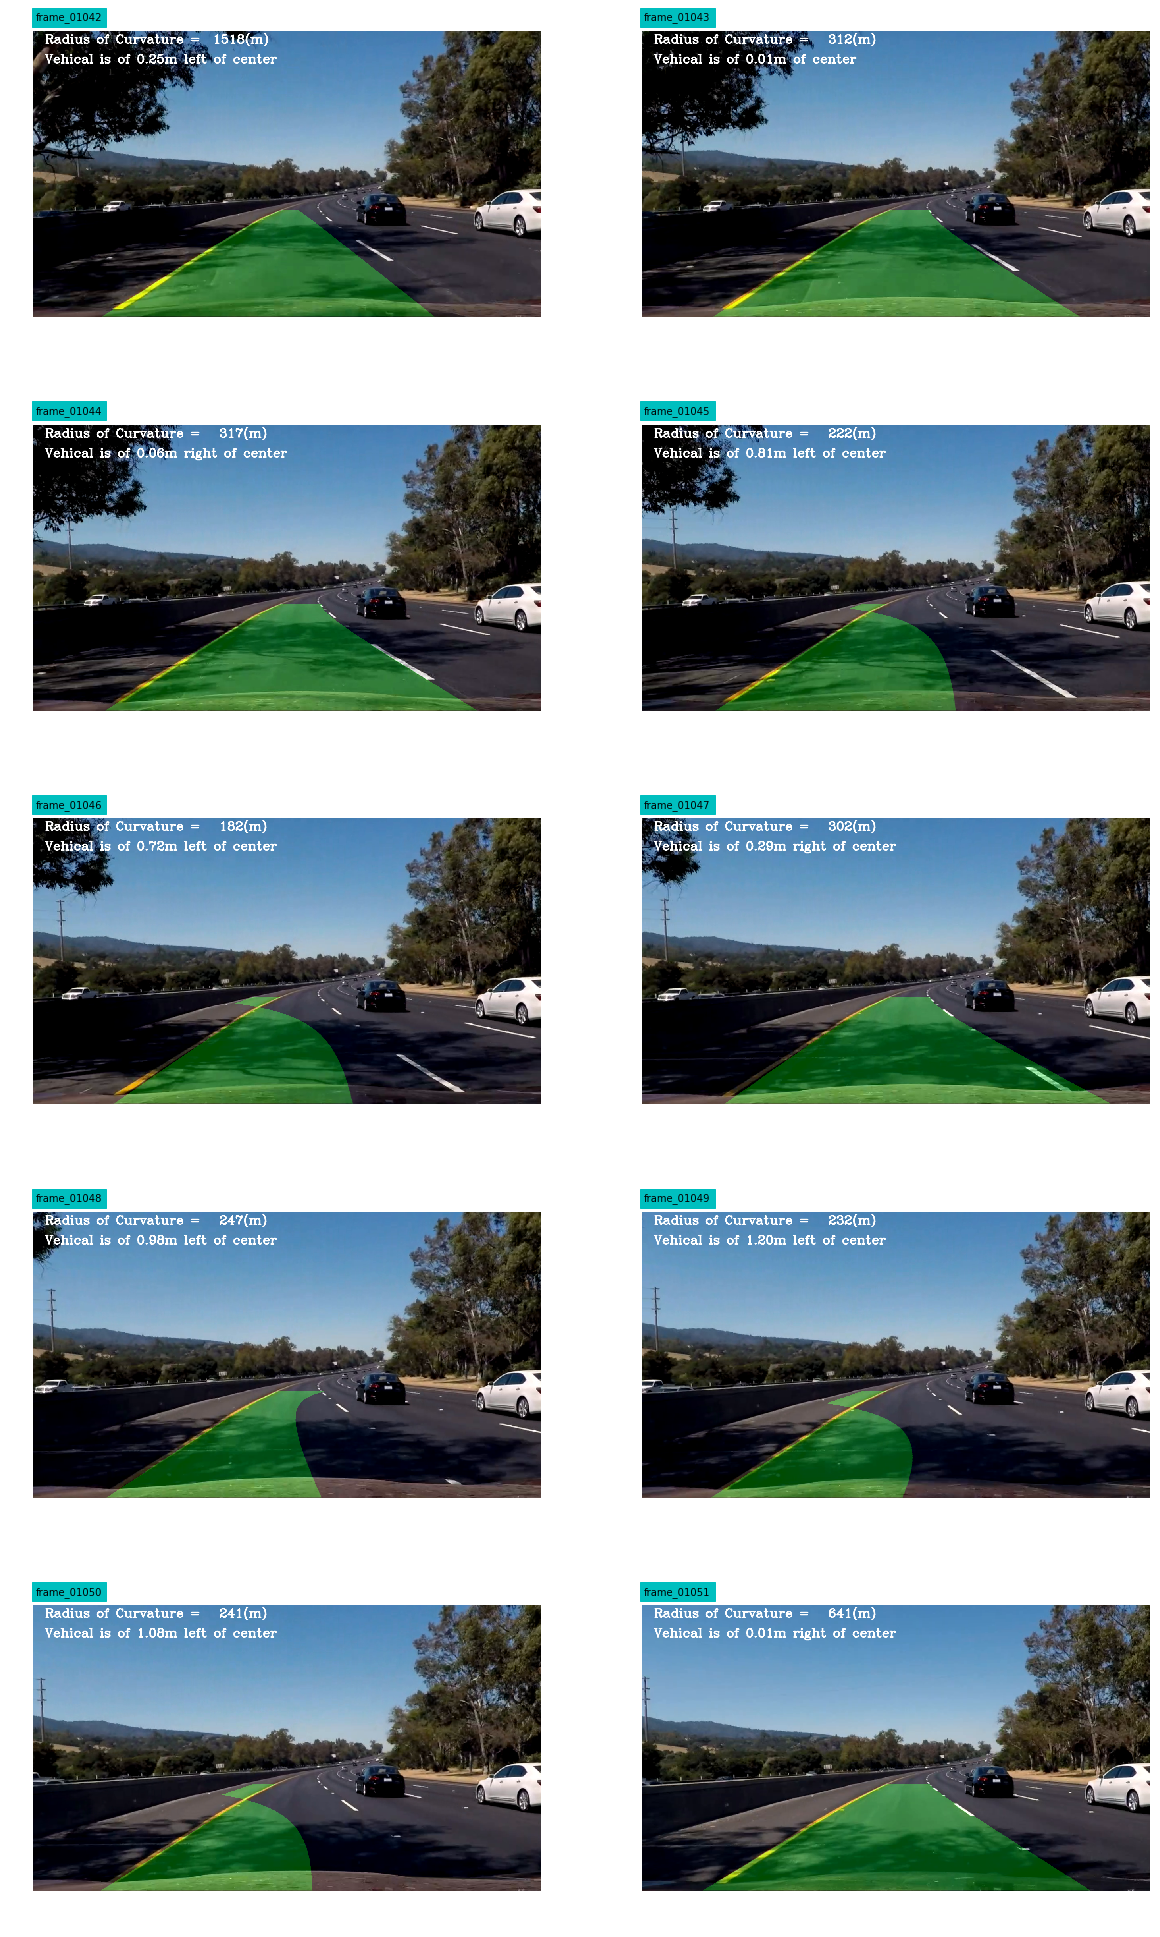

In [17]:
lane_line_imgs = []
labels = []
# (585, 595)
# (1042,1052)
for i in range(1042,1052):    
    raw_bgr = cv2.imread('video_frame/project_video/frame_{:05d}.png'.format(i))
    raw_rgb = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)
    lane_line = pipeline_single_image(raw_rgb, mtx, dist)
    lane_line_imgs.append(lane_line)
    labels.append('frame_{:05d}'.format(i))

grid_view(lane_line_imgs, labels, (20, 35), 5, 2)

The issue occurs between frame 1045 to 1050. Let's look at one frame to understand why this happens?

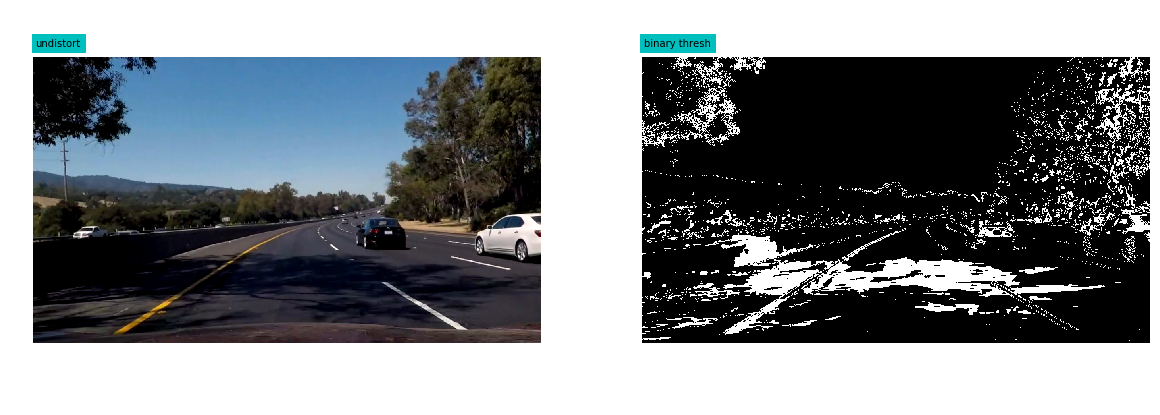

In [18]:
frame_1045 = cv2.cvtColor(cv2.imread('video_frame/project_video/frame_{:05d}.png'.format(1045)), cv2.COLOR_BGR2RGB)
frame_1045_undist = cv2.undistort(frame_1045, mtx, dist, None, mtx)
frame_1045_bin = binary_threshold_v1(frame_1045_undist)
frame_1045_bin_wraped = warper(frame_1045_bin)
view_imgs([frame_1045_undist, frame_1045_bin], ['undistort', 'binary thresh'], figsize=(20,7), cmaps={1:'gray'})

It's clear that the shadow in the image causes noise in the binary image, it causes the lane-finding algorithm failed to identify the right lane

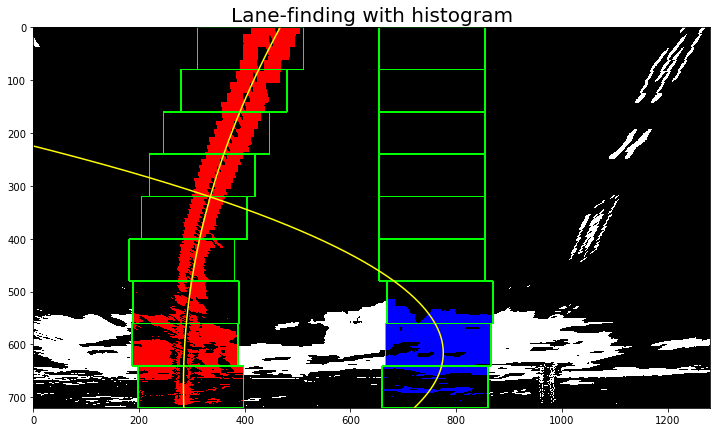

In [19]:
hist_lr_fits, hist_lr_points, hist_lr_windows = find_lane_line_hist(frame_1045_bin_wraped, 9, debug=True)
visualize_lane_line(frame_1045_bin_wraped, hist_lr_fits, hist_lr_points, hist_lr_windows, 'Lane-finding with histogram')

### Review binary threshold
After reviewing the binary threshold, we find that by combining both H & S channel, it improves the stability of binary threshold (works better in tricky lightning condition). It's implemented in `binary_threshold_v2`

In [20]:
out_clip2 = 'project_video_naive_v2.mp4'
pipeline_video_naive(in_clip, mtx, dist, out_clip2, bin_fn=binary_threshold_v2)

[MoviePy] >>>> Building video project_video_naive_v2.mp4
[MoviePy] Writing video project_video_naive_v2.mp4


100%|█████████▉| 1260/1261 [03:53<00:00,  5.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_naive_v2.mp4 

File is saved to project_video_naive_v2.mp4


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_clip2))

We can see it works better than the first version in tricky lightning condition. However it failes near the second 24th which is corresponding to frames (585-595). There are three frames (587,588,589) that we made mistakes on lane-line dection. 

We investigate the frame 587-th one

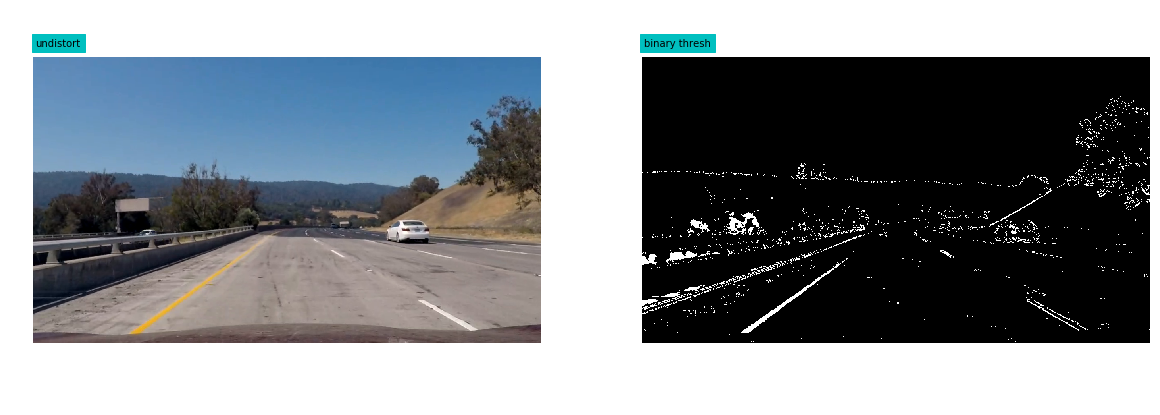

In [22]:
frame_587 = cv2.cvtColor(cv2.imread('video_frame/project_video/frame_{:05d}.png'.format(587)), cv2.COLOR_BGR2RGB)
frame_587_undist = cv2.undistort(frame_587, mtx, dist, None, mtx)
frame_587_bin = binary_threshold(frame_587_undist)
frame_587_bin_wraped = warper(frame_587_bin)
view_imgs([frame_587_undist, frame_587_bin], ['undistort', 'binary thresh'], figsize=(20,7), cmaps={1:'gray'})

One can see that the left wall is the main reason that makes the algorithm to identify incorrectly the lane line.

As suggested in the project page, we will use the previous frames to define a dynamics region of interest instead of doing the blind-search for every frame.

In [23]:
from pipeline import pipeline_video_look_ahead
out_clip3 = 'project_video_look_ahead.mp4'
pipeline_video_look_ahead(in_clip, mtx, dist, out_clip3)

[MoviePy] >>>> Building video project_video_look_ahead.mp4
[MoviePy] Writing video project_video_look_ahead.mp4


100%|█████████▉| 1260/1261 [03:51<00:00,  5.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_look_ahead.mp4 

File is saved to project_video_look_ahead.mp4


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_clip3))

## Challenge video
Now, we test our pipeline on the challenge videos

In [28]:
challenge_in1 = 'challenge_video.mp4'
challenge_out1 = 'challenge_video_out.mp4'

pipeline_video_naive(challenge_in1, mtx, dist, challenge_out1)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [01:29<00:00,  5.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

File is saved to challenge_video_out.mp4


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_out1))